# Modelagem de Aprendizado de Máquina para Previsão de Doenças Hepáticas

Trabalho realizado para disciplina de Aprendizado de Máquina <br>

## Autores
Alceu Lima Junior - 182705 <br>
Gabriela Bellardinelli Oliveira  - 230135 <br>
Otávio von Ameln Lovison - 291883


## Data
Data de Submissão: 26 de agosto de 2023

## Instituição
Universidade Federal do Rio Grande do Sul
Instituto de informática/PPGC

## Versão
1.0.1

# 1. Ambiente

Bibliotecas para instalação do ambiente

In [114]:
pip install xgboost

In [115]:
pip install shap


In [116]:
pip install imbalanced-learn

## 1.1 Bibliotecas

In [117]:
#Manipulacao e dataviz
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from google.colab import autoviz


#Utilidades
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from imblearn.over_sampling import RandomOverSampler
import shap
import pickle

from sklearn.model_selection import GridSearchCV

#Bibliotecas modelos
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

#Teste
from sklearn.model_selection import RepeatedKFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, confusion_matrix, classification_report, roc_curve, roc_auc_score,fbeta_score,precision_recall_curve


# 2. Auxiliar

## 2.1 Funções auxiliares

Funções Auxiliares utilizadas ao longo do notebook: <br>
modelsearch - utilizada para treinar diferentes modelos; <br>
get_index_of_max - utilizada para retornar o índice do melhor escore na validação cruzada; <br>
save_results - utilizada para guardar os resultados das execuções dos diferentes modelos




### 2.1.1 modelsearch

**modelsearch** <br>

| Entrada | Descrição |
|---------|-------------|
model | Modelo a ser treinado
scaler | Escalador (Ajuste de escala)
param_grid | Lista de hiperparâmetros para o ajuste
X_train | Número de partições para a validação cruzada
score_search | Escores utilizados no ajuste de hiperparâmetros
scores | Escores retornados na validação cruzada

In [118]:
def modelsearch(model, scaler, param_grid, X_train, y_train, num_folds, score_search, scores):
    # Realizando o over sample
    oversampler = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

    #Etapas do pipelines
    if scaler is None:
        steps = [
            ('classifier', model)  # Step 2: Trainamento modelo
        ]
    else:
        steps = [
            ('scaler', scaler),     # Step 1: Ajuste de escala quando necessario
            ('classifier', model)  # Step 2: Trainamento modelo
        ]

    # Criação do objeto pipeline
    pipeline = Pipeline(steps)

    # Inicializando o objeto de criação de partições externas
    cv_outer = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    # Inicializando o objeto de criação de partições internas
    cv_inner = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    # Inicializando a busca de hiperparametrosd com GridSearch
    search = GridSearchCV(pipeline, param_grid, scoring=score_search, n_jobs=1, cv=cv_inner, refit=True)

    # Validação cruzada aninhada
    output_ncv = cross_validate(search, X_train_resampled, y_train_resampled, scoring=scores, cv=cv_outer,
                                     n_jobs=-1, return_estimator=True, return_train_score=True)

    return output_ncv

### 2.1.2 get_index_of_max

**get_index_of_max** <br>

| Entrada | Descrição |
|---------|-------------|
arr | vetor com o resultados de escore

In [119]:
def get_index_of_max(arr):
    max_value = float('-inf')  # Initialize max_value to negative infinity
    max_index = -1  # Initialize max_index to -1

    for i in range(len(arr)):
        if arr[i] > max_value:
            max_value = arr[i]
            max_index = i

    return max_index

### 2.1.3 save_results

Função pra guardar os resultados pra comparação e melhor estimador

In [120]:
def save_results(results_dict, metrics_list, score_search,algorithm_name):

  score_search = score_search.name if type(f2_scorer) != str else score_search

  #Salva as médias das metricas no dicionario
  for metric in metrics_list:
      results_dict[metric][algorithm_name] = np.mean(results[metric])

  #Salvar o estimador no dicionario
  #indice do estimador com melhor parametro
  best_param_index=get_index_of_max(results['test_'+score_search])

  #objeto estimador desse indice
  estimator = results['estimator'][best_param_index].best_estimator_

  #salvando o melhor estimador dentro do dicionario
  results_dict['estimator'][algorithm_name] = estimator

  return results_dict

### 2.1.4 Variáveis auxiliares

Padronizando as visualizações

In [121]:
sns.set_style("whitegrid")
palette =["#614BC3","#33BBC5","#9F0D7F","#35155D","#61677A"]
map=sns.color_palette("magma", as_cmap=True)

### 2.1.5 Gráficos

In [122]:
def features_hist(df, drop_list):
  df = df.drop(drop_list, axis=1)

  num_cols = df.shape[1]
  num_rows = (num_cols + 2) // 3

  fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(8, 2*num_rows))
  for i, col in enumerate(df.columns):
      row_idx = i // 3
      col_idx = i % 3

      sns.histplot(df[col], ax=axes[row_idx, col_idx], kde=False, color=palette[0])
      axes[row_idx, col_idx].set_title(f'Histograma {col}', size=10)
      axes[row_idx, col_idx].set_xlabel(col, size=10)
      axes[row_idx, col_idx].set_ylabel('Frequencia', size=8)


  for i in range(num_cols, num_rows*3):
      fig.delaxes(axes.flatten()[i])

  plt.tight_layout()
  plt.show()

In [123]:
def features_boxplot(df, drop_list):
  df = df.drop(drop_list, axis=1)

  num_cols = df.shape[1]
  num_rows = (num_cols + 2) // 3

  fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(8, 2*num_rows))

  for i, col in enumerate(df.columns):
      row_idx = i // 3
      col_idx = i % 3

      sns.boxplot(df[col], ax=axes[row_idx, col_idx], color=palette[0])
      axes[row_idx, col_idx].set_title(f'Boxplot {col}', size=10)
      axes[row_idx, col_idx].set_xlabel(col, size=8)

  for i in range(num_cols, num_rows*3):
      fig.delaxes(axes.flatten()[i])

  plt.tight_layout()
  plt.show()

# 3. Importar dados

In [124]:
# Arquivo hospedado no google drive
# Fonte: https://www.kaggle.com/datasets/uciml/indian-liver-patient-records
data_url = 'https://drive.google.com/uc?export=download&id=15HflPnVIi8ThIxexNotkiEgVzDv8GNon'
df = pd.read_csv(data_url)

In [125]:
df.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Gender                      583 non-null    object 
 2   Total_Bilirubin             583 non-null    float64
 3   Direct_Bilirubin            583 non-null    float64
 4   Alkaline_Phosphotase        583 non-null    int64  
 5   Alamine_Aminotransferase    583 non-null    int64  
 6   Aspartate_Aminotransferase  583 non-null    int64  
 7   Total_Protiens              583 non-null    float64
 8   Albumin                     583 non-null    float64
 9   Albumin_and_Globulin_Ratio  579 non-null    float64
 10  Dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


# 4. Análise Exploratória e Pré processamento

| Atributo | Descrição |Inervalo de referência|
|---------|-------------|------------------|
|Age of the patient | Idade |NA |
Gender of the patient |Gênero |NA |
Total Bilirubin | Bilirubina - Níveis tanto da bilirrubina não conjugada quanto da bilirrubina conjugada no sangue|0.1 - 1.2 mg/dL
Direct Bilirubin | Bilirrubina Direta - Bilirrubina processada pelo fígado e pronta para eliminação| < 0.4 mg/dL  
Alkaline Phosphatase | Fosfatase Alcalina - Enzima presente em diversos tecidos, principalmente no fígado |12 - 43 U/L  
Alanine Aminotransferase | Alanina Aminotransferase (ALT) - Enzima encontrada principalmente no fígado; indicação de dano hepático| M: < 46; F: < 35
Aspartate Aminotransferase | Aspartato Aminotransferase (AST) - Enzima encontrada em múltiplos tecidos, incluindo o fígado; indicação de lesão hepática | M: < 40; F: < 38  
Total Proteins | Quantidade total de proteínas no sangue | 6 - 8 g/dL
Albumin | Albumina - Tipo específico de proteína no sangue| 3.5 - 5.5 g/dL
Albumin and Globulin Ratio | Relação Albumina/Globulina - Proporção entre os níveis de albumina e globulina no sangue| 1.1 - 2.5

<br>
Dataset: liver disease


Analisando as estatísticas gerais do dataset mostram resultados baixos e esperados para abulmina, o que pode indicar que a variável terá um menor poder de explicação dos resultados. As demais taxas, se comparadas com os dados de literatura, tem uma leve tendência acima devido aos pacientes doentes.

In [127]:
df.describe()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,579.000000,583.000000
mean,44.746141,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.947064,1.286449
std,16.189833,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.319592,0.452490
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,1.000000
25%,33.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,1.000000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.930000,1.000000
75%,58.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000,2.000000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,2.000000


## 4.1 Limpeza de dados

Quantidade de campos nulos por coluna

In [128]:
df.isnull().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64

Tratamento de campos nulos

In [129]:
mask_nulos = df.isnull().any(axis=1)

df[mask_nulos]

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
209,45,Female,0.9,0.3,189,23,33,6.6,3.9,NaN,1
241,51,Male,0.8,0.2,230,24,46,6.5,3.1,NaN,1
253,35,Female,0.6,0.2,180,12,15,5.2,2.7,NaN,2
312,27,Male,1.3,0.6,106,25,54,8.5,4.8,NaN,2


In [130]:
df = df[~mask_nulos]

Encontrar campos duplicados

In [131]:
df[df.duplicated()].count()

Age                           13
Gender                        13
Total_Bilirubin               13
Direct_Bilirubin              13
Alkaline_Phosphotase          13
Alamine_Aminotransferase      13
Aspartate_Aminotransferase    13
Total_Protiens                13
Albumin                       13
Albumin_and_Globulin_Ratio    13
Dataset                       13
dtype: int64

In [132]:
df = df.drop_duplicates(keep='first')

Convertendo classe em binário

In [133]:
df['Disease'] = df['Dataset'].replace({1: 1, 2: 0})
df['Gender'] = df['Gender'].replace({'Female': 0, 'Male': 1})
df.drop('Dataset',axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Arrumando o nome da feature

In [134]:
df.rename(columns={'Total_Protiens': 'Total_Proteins', 'Alkaline_Phosphotase': 'Alkaline_Phosphatase', 'Alamine_Aminotransferase': 'Alanine_Aminotransferase'}, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## 4.2 Remoção de Outliers

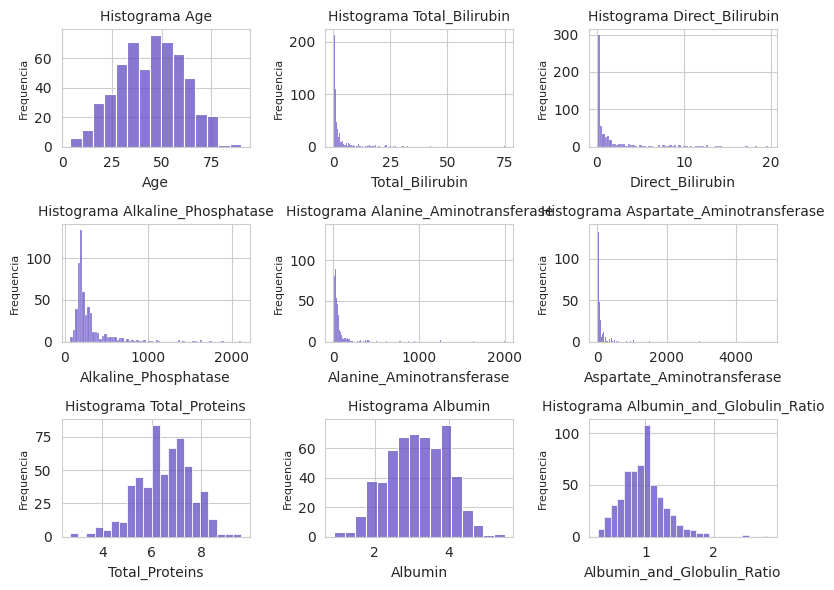

In [135]:
features_hist(df, ['Gender', 'Disease'])

Percebe-se algumas distribuições de cauda longa; <br>
Pode existir vies e menor performance no gênero feminino;<br>
Alkaline_Phosphatase, Alanine_Aminotransferase e Aspartate_Aminotransferase tem grande variação de escala; <br>

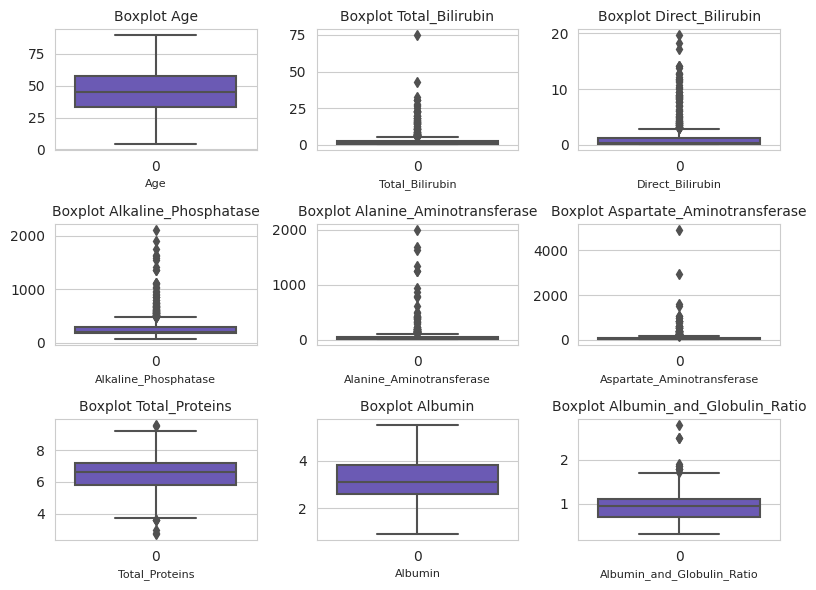

In [136]:
features_boxplot(df, ['Gender', 'Disease'])

O boxplot mostra a existência de outliers

Remoção de outlier com IQR

In [137]:

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
outlier_threshold=2.5

lower_bound = Q1 - outlier_threshold * IQR
upper_bound = Q3 + outlier_threshold * IQR
outliers = df[(df < lower_bound) | (df > upper_bound)]

df[(df < lower_bound) | (df > upper_bound)].describe()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphatase,Alanine_Aminotransferase,Aspartate_Aminotransferase,Total_Proteins,Albumin,Albumin_and_Globulin_Ratio,Disease
count,0.0,138.0,64.000000,58.000000,42.000000,49.000000,45.000000,0.0,0.0,3.000000,0.0
mean,NaN,0.0,17.489062,8.841379,995.000000,481.224490,738.222222,NaN,NaN,2.600000,NaN
std,NaN,0.0,10.527306,3.609589,399.308732,448.384752,793.197611,NaN,NaN,0.173205,NaN
min,NaN,0.0,7.300000,4.100000,610.000000,157.000000,245.000000,NaN,NaN,2.500000,NaN
25%,NaN,0.0,10.825000,6.025000,687.000000,190.000000,367.000000,NaN,NaN,2.500000,NaN
50%,NaN,0.0,15.700000,8.450000,854.500000,321.000000,511.000000,NaN,NaN,2.500000,NaN
75%,NaN,0.0,22.525000,11.175000,1120.500000,482.000000,850.000000,NaN,NaN,2.650000,NaN
max,NaN,0.0,75.000000,19.700000,2110.000000,2000.000000,4929.000000,NaN,NaN,2.800000,NaN


In [138]:
columns_outlier = ['Total_Bilirubin','Direct_Bilirubin' ]
for i in columns_outlier:
  df = df[(df[i] > lower_bound[i]) & (df[i] < upper_bound[i])]
df.describe()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphatase,Alanine_Aminotransferase,Aspartate_Aminotransferase,Total_Proteins,Albumin,Albumin_and_Globulin_Ratio,Disease
count,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000
mean,44.771084,0.742972,1.512048,0.606627,269.650602,63.831325,79.082329,6.503815,3.211446,0.970522,0.676707
std,16.478381,0.437434,1.298465,0.702264,215.831550,134.707238,143.652468,1.103299,0.795339,0.289316,0.468204
min,4.000000,0.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,0.000000
25%,33.000000,0.000000,0.725000,0.200000,172.250000,22.000000,24.000000,5.900000,2.700000,0.800000,0.000000
50%,45.000000,1.000000,0.900000,0.200000,202.000000,32.000000,37.000000,6.600000,3.200000,1.000000,1.000000
75%,58.000000,1.000000,1.800000,0.800000,282.000000,55.000000,68.000000,7.200000,3.900000,1.100000,1.000000
max,90.000000,1.000000,6.800000,3.600000,2110.000000,1680.000000,1500.000000,9.600000,5.500000,1.900000,1.000000


Foi utilizado um IQR mais relaxado, devido a existência de poucas instâncias

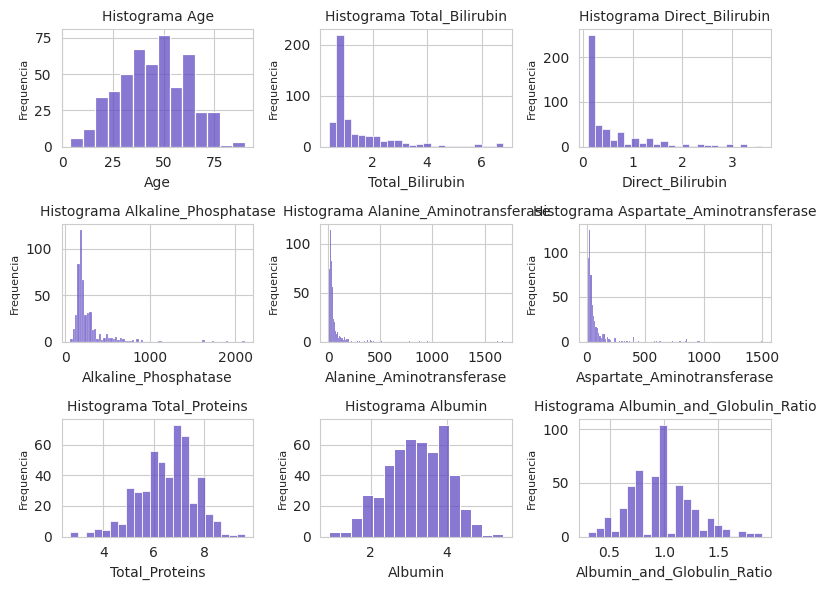

In [139]:
features_hist(df, ['Gender', 'Disease'])

Após a remoção de outliers reduziu o numero de instancias na cauda longa do grafico

## 4.3 Análise Exploratória

The palette list has more values (5) than needed (2), which may not be intended.
The palette list has more values (5) than needed (2), which may not be intended.
The palette list has more values (5) than needed (2), which may not be intended.
The palette list has more values (5) than needed (2), which may not be intended.
The palette list has more values (5) than needed (2), which may not be intended.
The palette list has more values (5) than needed (2), which may not be intended.
The palette list has more values (5) than needed (2), which may not be intended.
The palette list has more values (5) than needed (2), which may not be intended.
The palette list has more values (5) than needed (2), which may not be intended.
The palette list has more values (5) than needed (2), which may not be intended.
The palette list has more values (5) than needed (2), which may not be intended.


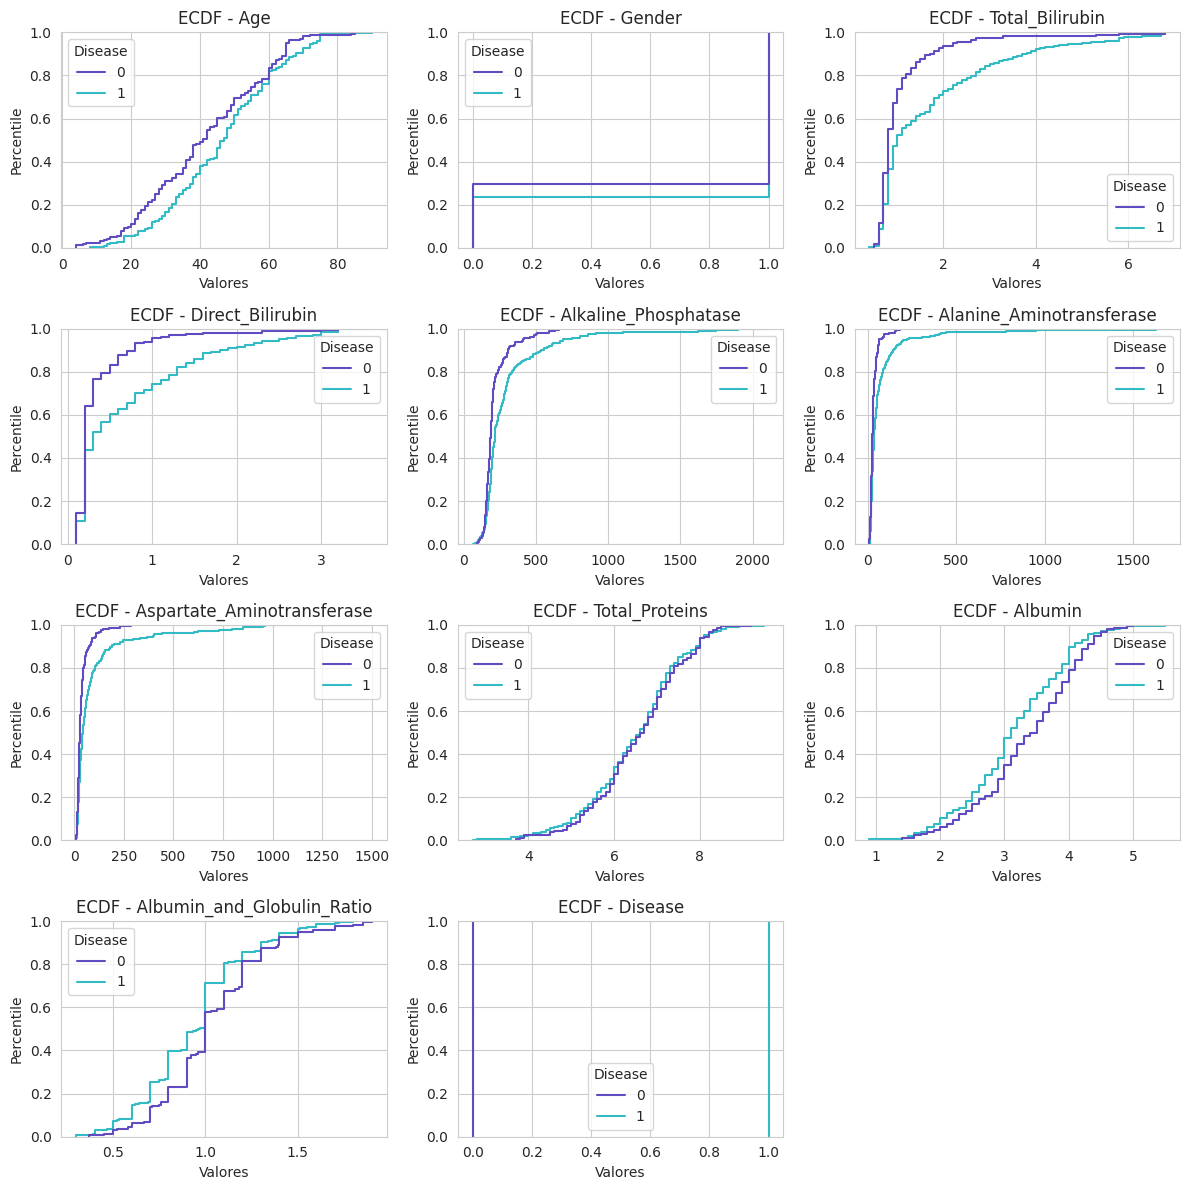

In [140]:

num_cols = df.shape[1]
num_rows = (num_cols + 2) // 3

fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(12, 3*num_rows))


for i, col in enumerate(df.columns):
    row_idx = i // 3
    col_idx = i % 3

    sns.ecdfplot(data=df, x=col, hue="Disease", ax=axes[row_idx, col_idx], palette=palette)
    axes[row_idx, col_idx].set_xlabel('Valores')
    axes[row_idx, col_idx].set_ylabel('Percentile')
    axes[row_idx, col_idx].set_title(f'ECDF - {col}')
    axes[row_idx, col_idx].grid(True)


for i in range(num_cols, num_rows*3):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.savefig('ecdf.png')
plt.show()


Comparando o comportamento das preditoras abertas por classe: <br>
**Age**: Entre 20 e 50 anos parece haver uma diferença maior entre o comportamento e diferenciação;
**Total bilirubin, Direct Bilirubin, Alkaline_Photophotase, Alamine_Aminotransferase**: Parece ser mais significativa quanto maior o valor <br>
**Aspartate_Aminotransferase**: Parece ter baixo impacto, a partir de 80% do valor <br>
**Total Protiens**: Parece ter baixo impacto em toda a distribuição.

<Axes: >

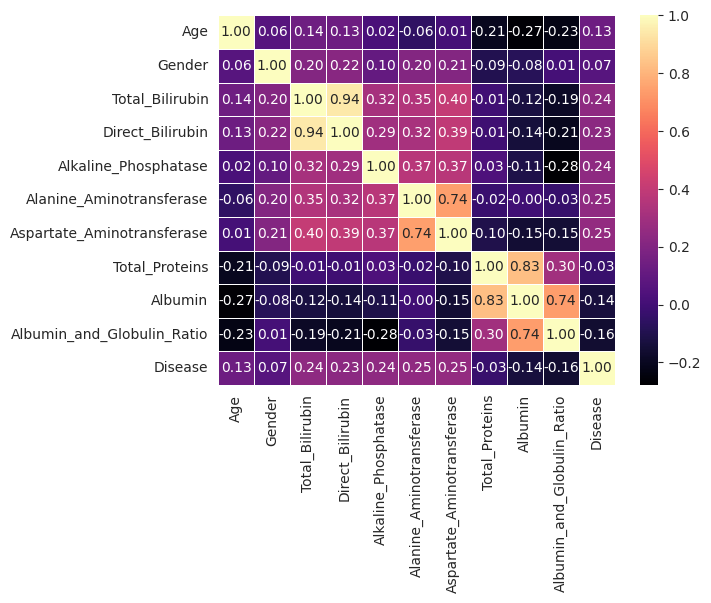

In [141]:
figsize=(60, 60)
sns.heatmap(df.corr(method='spearman'), annot = True, linewidth=.5, cmap=map, fmt=".2f" )

Existem atributos com correlação: Direct_Bilirubin e Total_Bilirubin, Aspartate_aminotransferase e Alanine_Aminotransferase, Albumin, Total_Proteins e Albumin_and_Globulin_Ratio.

# 5. Seleção de atributos

Utilização de Random forest aninhado para indicação de Features mais relevantes para o dataset

In [142]:
df.columns

Index(['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin',
       'Alkaline_Phosphatase', 'Alanine_Aminotransferase',
       'Aspartate_Aminotransferase', 'Total_Proteins', 'Albumin',
       'Albumin_and_Globulin_Ratio', 'Disease'],
      dtype='object')

In [143]:
# Dividindo o dado entre features (X) e alvo (y)
X = df.drop(['Disease'], axis=1)
y = df['Disease']

In [144]:
# Dividindo em teste e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Utilização de algoritmos de random forest subsequentes para verificação da importancia das variáveis.

**Random forest 1** <br>
aplica o algoritmo uma vez para visualização do impacto dos atributos

              precision    recall  f1-score   support

           0       0.51      0.38      0.43        48
           1       0.74      0.83      0.78       102

    accuracy                           0.69       150
   macro avg       0.63      0.60      0.61       150
weighted avg       0.67      0.69      0.67       150



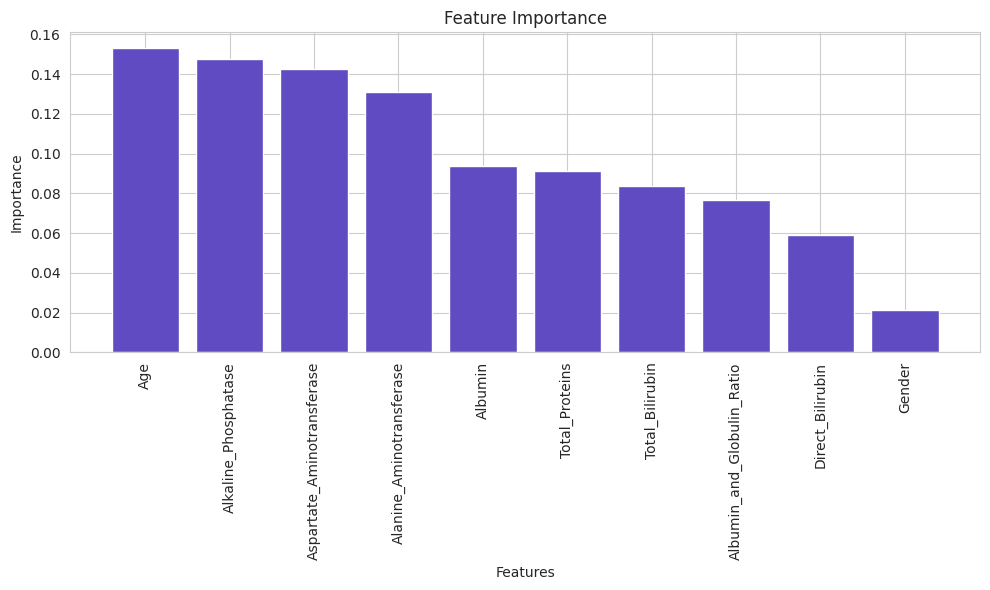

In [145]:
# Random Forest para importância de features
clf = RandomForestClassifier(random_state=42)

# Fitting the classifier to the training data
clf.fit(X_train, y_train)

# Importância de features
feature_importances = clf.feature_importances_

# Gerando o df de importância de features
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Sorting
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotando a importância de features
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], color=palette[0])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


**Random forest 2** <br>
Aplica o método mais uma vez, para verificação se as variáveis se mantém relevantes sem Gender  e Direct_Bilirubin.

In [146]:
# Dividindo o dado entre features (X) e alvo (y)
X2 = df.drop(['Disease','Gender','Direct_Bilirubin'], axis=1)
y2 = df['Disease']
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2, y2, test_size=0.3, random_state=42)

              precision    recall  f1-score   support

           0       0.52      0.23      0.32        48
           1       0.71      0.90      0.80       102

    accuracy                           0.69       150
   macro avg       0.62      0.57      0.56       150
weighted avg       0.65      0.69      0.64       150



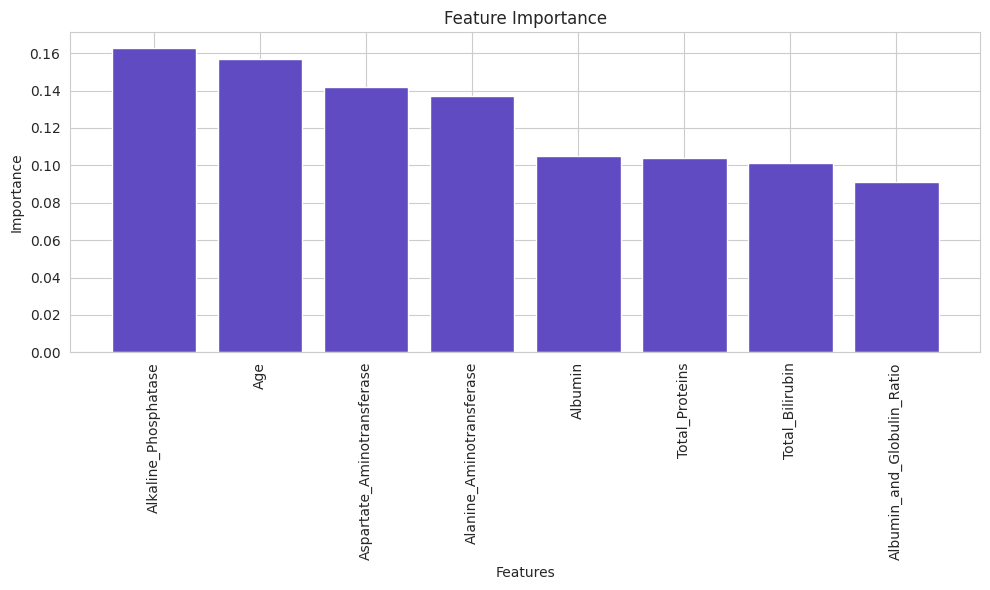

In [147]:
# Random Forest para importância de features
clf = RandomForestClassifier(random_state=42)

# Fitting the classifier to the training data
clf.fit(X_train_2, y_train_2)

# Importância de features
feature_importances = clf.feature_importances_

# Gerando o df de importância de features
importance_df = pd.DataFrame({'Feature': X2.columns, 'Importance': feature_importances})

y_pred = clf.predict(X_test_2)
print(classification_report(y_test_2, y_pred))

# Sorting
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotando a importância de features
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], color=palette[0])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


Foram eliminadas do dataset variáveis com menos impacto na distribuição como Gender e Direct_Bilirubin, que também possui alta correlação com Total_Bilirubin. Age foi eliminada para evitar possíveis viéses relacionados a idade, com o intuito de se basear apenas nos resultados de exames. A segunda seleção manteve a maioria dos atributos na mesma ordem de importância. Sendo o menor deles Albumin_and_Globulin_Ratio.

In [148]:
#Removendo Age e Gender das features
excluir_features = ['Age','Gender', 'Direct_Bilirubin','Albumin_and_Globulin_Ratio']
X = df.drop(['Disease'] + excluir_features, axis=1)
y = df['Disease']

# 6. Desbalanceamento de classes

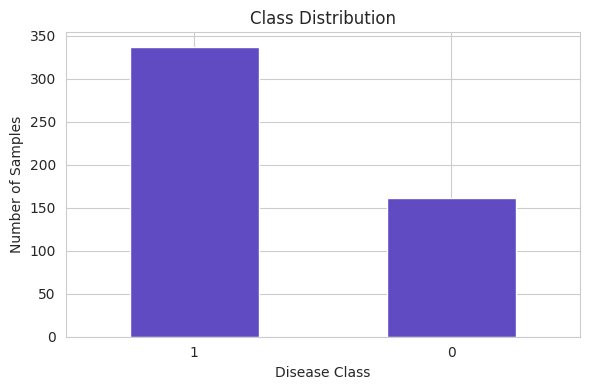

Class Counts:
1    337
0    161
Name: Disease, dtype: int64


In [149]:
# Contando as classes
class_counts = df['Disease'].value_counts()

# Plotando a distribuição
plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=palette[0])
plt.xlabel('Disease Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Print
print("Class Counts:")
print(class_counts)


Desbalanceamento de gênero

In [150]:
print(pd.crosstab(df['Gender'], df['Disease']))

Disease    0    1
Gender           
0         48   80
1        113  257


Em função do desbalanceamento de classes, será necessário utilizar um método de correção. Optamos pelo RandomOverSampler no set de treinamento.

# 7. Split

Divisão externa ao cross validation para avaliação final do modelo escolhido.

In [151]:
# Dividindo em teste e treino novamente, após drop de features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# 8. Seleção de modelos e otimização de hiperparâmetros

(https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/)

## 8.1 Modelos

### 8.1.1 Parâmetros gerais

In [152]:
beta = 2
f2_scorer = make_scorer(fbeta_score, beta=beta)
f2_scorer.name = f'f{beta}'

#parametro para seleção de hiperparametros
score_search = f2_scorer
#métricas de saida da validação cruzada
scores = {
    'f1': 'f1',
    'accuracy': 'accuracy',
    'precision':'precision',
    'recall':'recall',
    'f2': f2_scorer
}
#numero de folds
num_folds=5

#parametros de resultados para analise
metrics_list = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1','test_f2']
results_dict = {metric: {} for metric in metrics_list}
results_dict['estimator'] = {}

### 8.1.2 Naive Bayes

In [153]:
# define o modelo
name='Naive Bayes'
model = GaussianNB()
scaler = MinMaxScaler()
param_grid = {}
results = modelsearch(model, scaler, param_grid, X_train, y_train, num_folds, score_search, scores)

In [154]:
print("Results:")
print("Accuracy:", np.mean(results['test_accuracy']))
print("Precision:", np.mean(results['test_precision']))
print("Recall:", np.mean(results['test_recall']))
print("F1:", np.mean(results['test_f1']))
print("F2:", np.mean(results['test_f2']))

Results:
Accuracy: 0.6357390100380755
Precision: 0.8396252787460217
Recall: 0.3382250174703004
F1: 0.4799099556998517
F2: 0.38336185010311874


In [155]:
results_dict = save_results(results_dict, metrics_list, score_search, name)

### 8.1.3 AdaBoost

In [156]:
name='Adaboost'

# Definindo o classificador AdaBoost
model = AdaBoostClassifier(random_state=42)

# Definindo o escalador
scaler = None

# Definindo o espaço de pesquisa para os hiperparâmetros
param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__learning_rate': [0.01, 0.1, 1],
    'classifier__algorithm': ['SAMME', 'SAMME.R']
    }

# Model Search
results = modelsearch(model, scaler, param_grid, X_train, y_train, num_folds=num_folds, score_search=score_search, scores=scores)

In [157]:
print("Results:")
print("Accuracy:", np.mean(results['test_accuracy']))
print("Precision:", np.mean(results['test_precision']))
print("Recall:", np.mean(results['test_recall']))
print("F1:", np.mean(results['test_f1']))
print("F2:", np.mean(results['test_f2']))

Results:
Accuracy: 0.7174454828660436
Precision: 0.7435912451340443
Recall: 0.6693221523410202
F1: 0.7037705446084256
F2: 0.6825381401225148


In [158]:
results_dict = save_results(results_dict, metrics_list, score_search, name)

### 8.1.4 XGboost

In [159]:
name='XGboost'

# define o modelo
model = xgb.XGBClassifier(random_state=42)
scaler = None
param_grid = {
    'classifier__learning_rate':[0.001,0.01, 0.1, 0.2],
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [5,10, 15,20],
    'classifier__gamma': [0, 0.1, 0.2]
    }


# Model Search
results = modelsearch(model, scaler, param_grid, X_train, y_train, num_folds=num_folds, score_search=score_search, scores=scores)

In [160]:
print("Results:")
print("Accuracy:", np.mean(results['test_accuracy']))
print("Precision:", np.mean(results['test_precision']))
print("Recall:", np.mean(results['test_recall']))
print("F1:", np.mean(results['test_f1']))
print("F2:", np.mean(results['test_f2']))

Results:
Accuracy: 0.7584112149532711
Precision: 0.8047394813648683
Recall: 0.6913347309573725
F1: 0.7404130194968703
F2: 0.7094880593002556


In [161]:
results_dict = save_results(results_dict, metrics_list, score_search, name)

### 8.1.5 KNN

(https://www.kaggle.com/code/melihkanbay/knn-best-parameters-gridsearchcv)

In [162]:
## Treinar um KNN
name='KNN'

#Definindo o modelo
model = KNeighborsClassifier()

#Scaler
scaler = MinMaxScaler()

#Param grid
param_grid={'classifier__n_neighbors': list(range(1, 17, 2)),
            'classifier__weights': ['uniform', 'distance']
            }

# Model Search
results = modelsearch(model, scaler, param_grid, X_train, y_train, num_folds=num_folds, score_search=score_search, scores=scores)

In [163]:
print("Results:")
print("Accuracy:", np.mean(results['test_accuracy']))
print("Precision:", np.mean(results['test_precision']))
print("Recall:", np.mean(results['test_recall']))
print("F1:", np.mean(results['test_f1']))
print("F2:", np.mean(results['test_f2']))

Results:
Accuracy: 0.7603322949117342
Precision: 0.8025
Recall: 0.6954577218728162
F1: 0.7428275593516799
F2: 0.7131906384901441


In [164]:
results_dict = save_results(results_dict, metrics_list, score_search, name)

### 8.1.6 SVM (SVC)

In [165]:
name='SVC'

#Definindo o modelo
model = SVC(random_state=42)

#Scaler
scaler = MinMaxScaler()

#Param grid
param_grid={'classifier__C': [0.1, 1, 5, 10, 50, 100],
            'classifier__gamma': [0.01, 0.05, 0.1, 0.5, 1.0],
            'classifier__kernel': ['linear', 'rbf', 'poly']}


# Model Search
results = modelsearch(model, scaler, param_grid, X_train, y_train, num_folds=num_folds, score_search=score_search, scores=scores)

In [166]:
print("Results:")
print("Accuracy:", np.mean(results['test_accuracy']))
print("Precision:", np.mean(results['test_precision']))
print("Recall:", np.mean(results['test_recall']))
print("F1:", np.mean(results['test_f1']))
print("F2:", np.mean(results['test_f2']))

Results:
Accuracy: 0.6410176531671858
Precision: 0.7211068878653728
Recall: 0.6
F1: 0.6182499821517813
F2: 0.5963902472293473


In [167]:
results_dict = save_results(results_dict, metrics_list, score_search, name)

### 8.1.7 Random Forest


In [168]:
name='Random Forest'

# Define modelo e grid de parâmetros
model = RandomForestClassifier(random_state=42)

scaler = None

param_grid = {'classifier__n_estimators': [100, 200, 500],
              'classifier__max_depth': [None, 5, 10, 20]
             }


# Model Search
results = modelsearch(model, scaler, param_grid, X_train, y_train, num_folds=num_folds, score_search=score_search, scores=scores)

In [169]:
print("Results:")
print("Accuracy:", np.mean(results['test_accuracy']))
print("Precision:", np.mean(results['test_precision']))
print("Recall:", np.mean(results['test_recall']))
print("F1:", np.mean(results['test_f1']))
print("F2:", np.mean(results['test_f2']))

Results:
Accuracy: 0.7937348563516788
Precision: 0.8383290011262094
Recall: 0.7287211740041929
F1: 0.7777602689105673
F2: 0.7471927169882583


In [170]:
results_dict = save_results(results_dict, metrics_list, score_search, name)

## 8.2 Comparação modelos

### 8.2.1 Resultados da validação cruzada

In [183]:
results_df = pd.DataFrame(results_dict).reset_index(names='model')
results_df.sort_values(by='test_f2', ascending=False)

,model,test_accuracy,test_precision,test_recall,test_f1,test_f2,estimator
5,Random Forest,0.793735,0.838329,0.728721,0.777760,0.747193,"((DecisionTreeClassifier(max_features='sqrt', ..."
3,KNN,0.760332,0.802500,0.695458,0.742828,0.713191,"(MinMaxScaler(), KNeighborsClassifier(n_neighb..."
2,XGboost,0.758411,0.804739,0.691335,0.740413,0.709488,"(XGBClassifier(base_score=None, booster=None, ..."
1,Adaboost,0.717445,0.743591,0.669322,0.703771,0.682538,"((DecisionTreeClassifier(max_depth=1, random_s..."
4,SVC,0.641018,0.721107,0.600000,0.618250,0.596390,"(MinMaxScaler(), SVC(C=0.1, gamma=0.01, random..."
0,Naive Bayes,0.635739,0.839625,0.338225,0.479910,0.383362,"(MinMaxScaler(), GaussianNB())"


### 8.2.1.1 Gráfico da validação cruzada

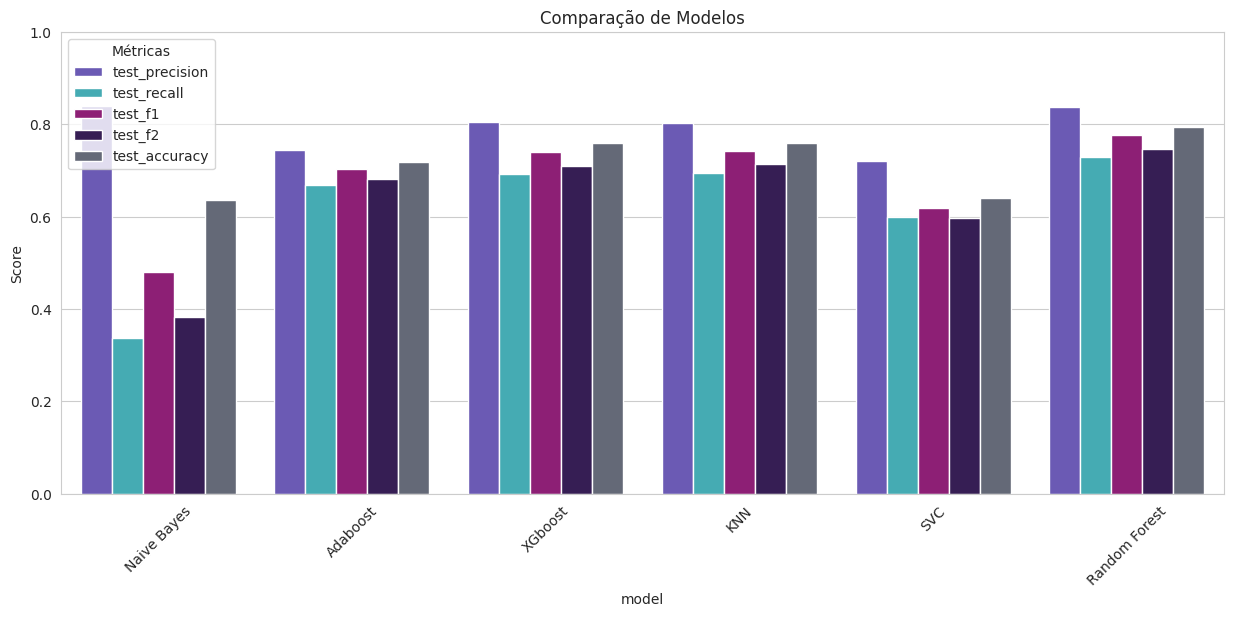

In [184]:
def plot_results_in_sample(results_df):

    melted_df = results_df.melt(id_vars='model', value_vars=['test_precision', 'test_recall', 'test_f1', 'test_f2', 'test_accuracy'])

    plt.figure(figsize=[15,6])
    sns.barplot(x='model', y='value', hue='variable', data=melted_df, palette=palette)
    plt.title('Comparação de Modelos')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.legend(title='Métricas')
    plt.show()

plot_results_in_sample(results_df)

### 8.2.2 Desempenho f2

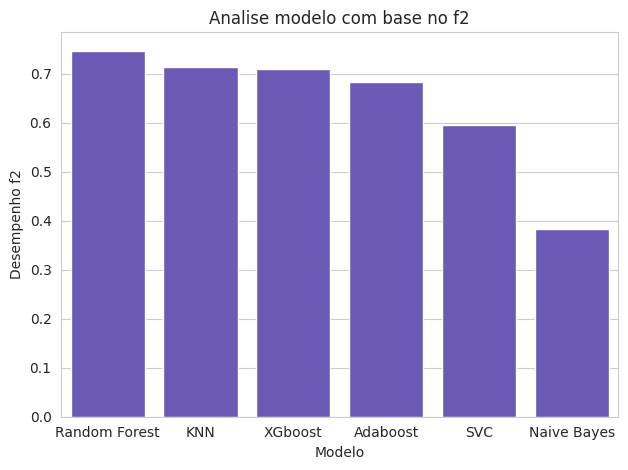

In [185]:
sns.barplot(x='model', y='test_f2', data=results_df.sort_values(by='test_f2', ascending=False), color=palette[0])
plt.xlabel('Modelo')
plt.ylabel('Desempenho f2')
plt.title('Analise modelo com base no f2')
plt.tight_layout()
plt.show()

### 8.2.2 Análise *out of sample* dos modelos

In [186]:
# Split para avaliação final
X_train_oos, X_test_oos, y_train_oos, y_test_oos = train_test_split(X_test, y_test, test_size=0.2, random_state=42, stratify=y_test)

#função para aplicar o mesmo escalar do melhor modelo
def apply_scaling(model, X_data):
  scaler_step = None
  if 'scaler' in model.named_steps:
    scaler_step = model.named_steps['scaler']

    return scaler_step.transform(X_data)
  else:
        return X_data

#função para realizar a comparação de modelos
def model_comparisson(models, X_train_p, X_test_p, y_train, y_test):
  results = []

  X_train_p = np.array(X_train_p)
  X_test_p = np.array(X_test_p)
  y_train = np.array(y_train)
  y_test = np.array(y_test)

  for model_name, model in models.items():
      X_train = apply_scaling(model, X_train_p)
      X_test = apply_scaling(model, X_test_p)

      model_refit = model.fit(X_train, y_train)
      y_pred = model_refit.predict(X_test)

      report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
      f2_score = fbeta_score(y_test, y_pred, beta=2, average='macro', zero_division=1)
      result = {
          'Model': model_name,
          'Precision': report['macro avg']['precision'],
          'Recall': report['macro avg']['recall'],
          'F1-Score': report['macro avg']['f1-score'],
          'F2-Score': f2_score,
          'Accuracy': report['accuracy']
      }
      results.append(result)
  results_df = pd.DataFrame(results)
  return results_df.sort_values(by='F2-Score', ascending=False)

print(model_comparisson(results_dict['estimator'], X_train_oos, X_test_oos, y_train_oos, y_test_oos))

           Model  Precision    Recall  F1-Score  F2-Score  Accuracy
2        XGboost   0.761905  0.761905  0.761905  0.761905      0.80
5  Random Forest   0.761905  0.761905  0.761905  0.761905      0.80
3            KNN   0.642857  0.642857  0.642857  0.642857      0.70
1       Adaboost   0.598901  0.607143  0.601140  0.604254      0.65
0    Naive Bayes   0.541667  0.547619  0.494949  0.512153      0.50
4            SVC   0.850000  0.500000  0.411765  0.460526      0.70


### Tabela comparativa antes e depois

In [187]:
analysis_df = results_df
analysis_df.drop(columns=["test_f1", "estimator", "test_recall", "test_precision"]).sort_values(by='model', ascending=False).reset_index(drop=True)[["model", "test_accuracy", "test_f2"]]

,model,test_accuracy,test_f2
0,XGboost,0.758411,0.709488
1,SVC,0.641018,0.596390
2,Random Forest,0.793735,0.747193
3,Naive Bayes,0.635739,0.383362
4,KNN,0.760332,0.713191
5,Adaboost,0.717445,0.682538


In [189]:
pd.DataFrame(model_comparisson(results_dict['estimator'], X_train_oos, X_test_oos, y_train_oos, y_test_oos)).drop(columns=["F1-Score", "Recall", "Precision"]).sort_values(by='Model', ascending=False).reset_index(drop=True)[["Accuracy", "F2-Score", "Model"]]

,Accuracy,F2-Score,Model
0,0.80,0.761905,XGboost
1,0.70,0.460526,SVC
2,0.80,0.761905,Random Forest
3,0.50,0.512153,Naive Bayes
4,0.70,0.642857,KNN
5,0.65,0.604254,Adaboost


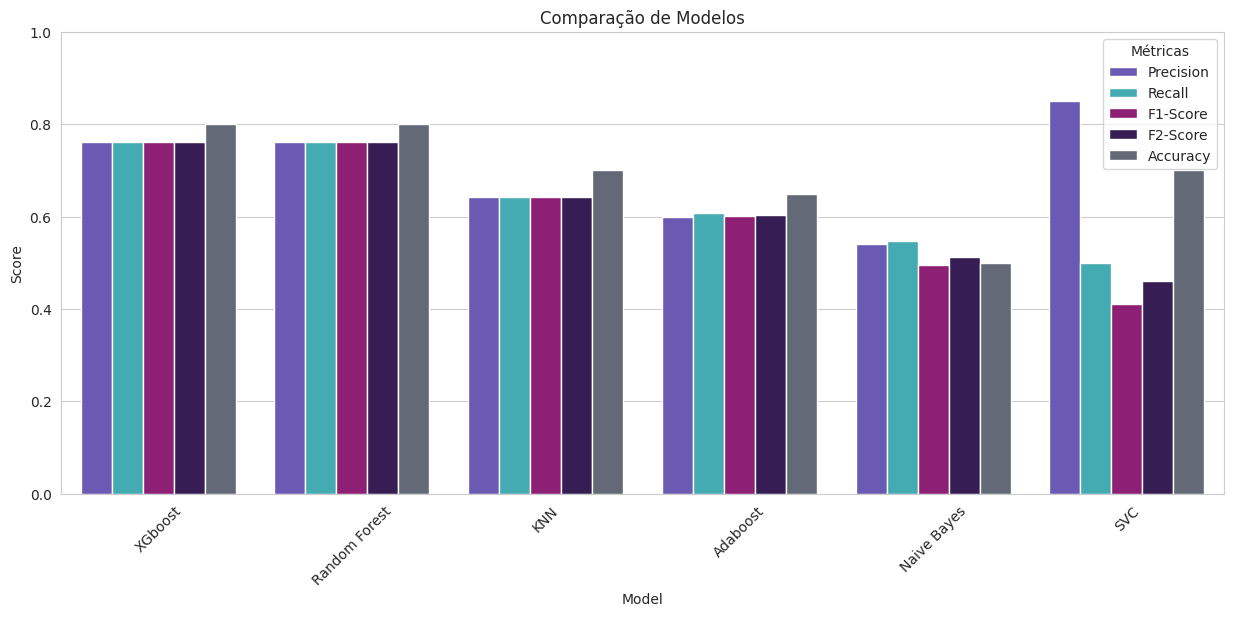

In [190]:
def plot_results(results_df):
    # Derrete o DataFrame para um formato longo, adequado para Seaborn
    melted_df = results_df.melt(id_vars='Model', value_vars=['Precision', 'Recall', 'F1-Score', 'F2-Score', 'Accuracy'])

    plt.figure(figsize=[15,6])
    sns.barplot(x='Model', y='value', hue='variable', data=melted_df, palette=palette)
    plt.title('Comparação de Modelos')
    plt.ylabel('Score')
    plt.ylim(0, 1) # Ajusta o limite do eixo y para que ele esteja no mesmo intervalo das métricas
    plt.xticks(rotation=45)
    plt.legend(title='Métricas')
    plt.show()

# Chama a função de comparação
results_df = model_comparisson(results_dict['estimator'], X_train_oos, X_test_oos, y_train_oos, y_test_oos)

# Plota os resultados
plot_results(results_df)

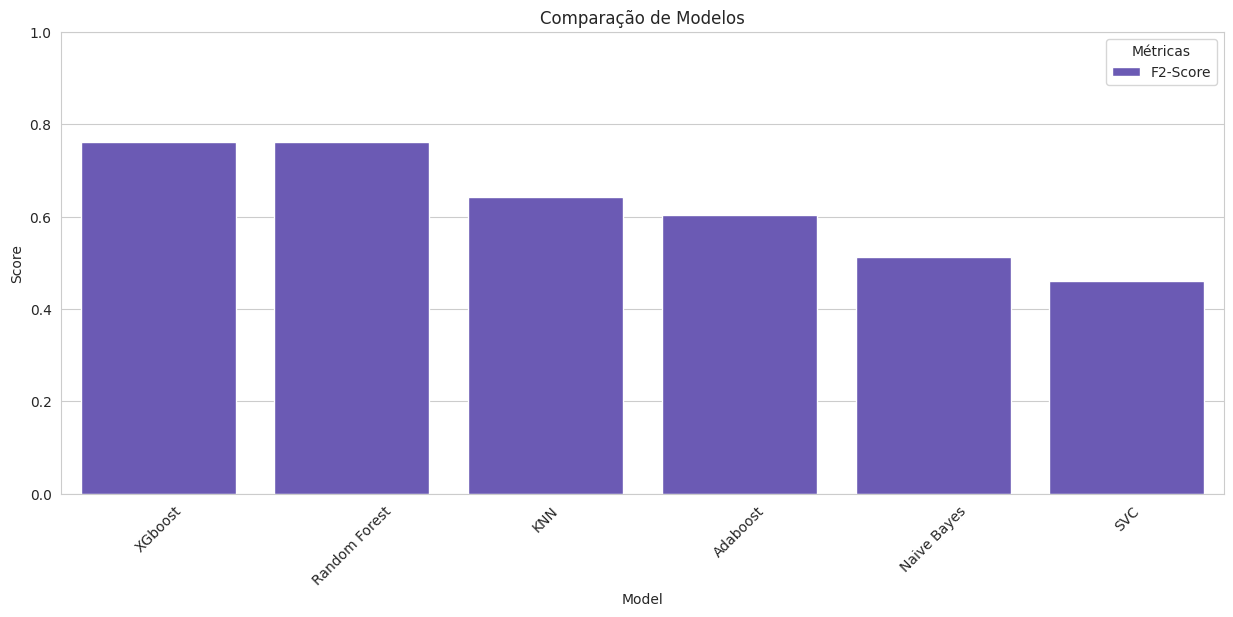

In [191]:
def plot_f2(results_df):
    # Derrete o DataFrame para um formato longo, adequado para Seaborn
    melted_df = results_df.melt(id_vars='Model', value_vars=['F2-Score'])

    plt.figure(figsize=[15,6])
    sns.barplot(x='Model', y='value', hue='variable', data=melted_df, palette=palette)
    plt.title('Comparação de Modelos')
    plt.ylabel('Score')
    plt.ylim(0, 1) # Ajusta o limite do eixo y para que ele esteja no mesmo intervalo das métricas
    plt.xticks(rotation=45)
    plt.legend(title='Métricas')
    plt.show()

# Plota os resultados
plot_f2(results_df)

# 9. Analise do modelo escolhido

In [192]:
X_train_oos, X_test_oos, y_train_oos, y_test_oos = train_test_split(X_test, y_test, test_size=0.2, random_state=42, stratify=y_test)

model_refit = results_dict['estimator']['Random Forest']
X_train_oos =  np.array(X_train_oos)
X_test_oos =  np.array(X_test_oos)
y_train_oos =  np.array(y_train_oos)
y_test_oos =  np.array(y_test_oos)

X_train_scaled_oos = apply_scaling(model_refit, X_train_oos)
X_test_scaled_oos = apply_scaling(model_refit, X_test_oos)

model_refit.fit(X_train_scaled_oos, y_train_oos)

y_pred = model_refit.predict(X_test_scaled_oos)

class_report = classification_report(y_test_oos, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.86      0.86      0.86        14

    accuracy                           0.80        20
   macro avg       0.76      0.76      0.76        20
weighted avg       0.80      0.80      0.80        20



## 9.1 Matriz de Confusão

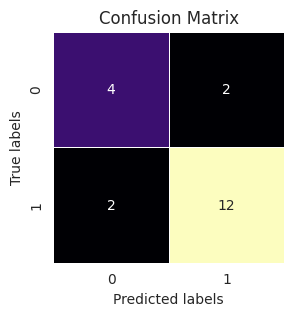

In [193]:
cm = confusion_matrix(y_test_oos, y_pred)

plt.figure(figsize=(5, 3))

sns.heatmap(cm, annot=True, fmt="d", cmap=map, cbar=False, square=True, linewidths=0.5)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()

## 9.2 Curva ROC

- Utilização: Pode ser usada para classes balanceadas ou desbalanceadas, oferecendo uma visão geral do desempenho do modelo.
- Interpretação: Um modelo perfeito terá uma área sob a curva ROC (AUC-ROC) de 1, enquanto um modelo aleatório terá uma AUC-ROC de 0,5.

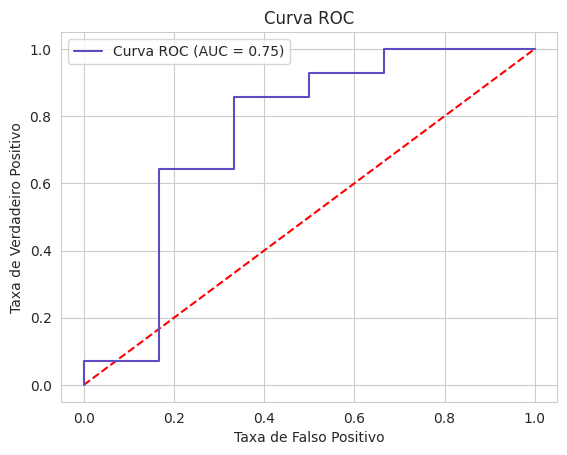

In [194]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Your code for prediction and ROC curve
y_scores = model_refit.predict_proba(X_test_oos)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_oos, y_scores)

# Find the point closest to the FPR equal to TPR
diffs = np.abs(fpr - (1 - tpr))
index = np.argmin(diffs)

# Halfway point on the ROC curve
halfway_point = (fpr[index] + (1 - tpr[index])) / 2

# Calculating the AUC
roc_auc = roc_auc_score(y_test_oos, y_scores)

# Plotting the ROC curve with AUC
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})', color=palette[0])  # Adjust color here
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend()
plt.show()


## 9.3 Curva PR

- Utilização: Particularmente útil quando se lida com classes desbalanceadas, onde a classe positiva é de interesse especial.
- Interpretação: Um modelo perfeito terá uma área sob a curva PR (AUC-PR) de 1, enquanto um modelo aleatório terá uma AUC-PR proporcional à proporção de exemplos positivos.


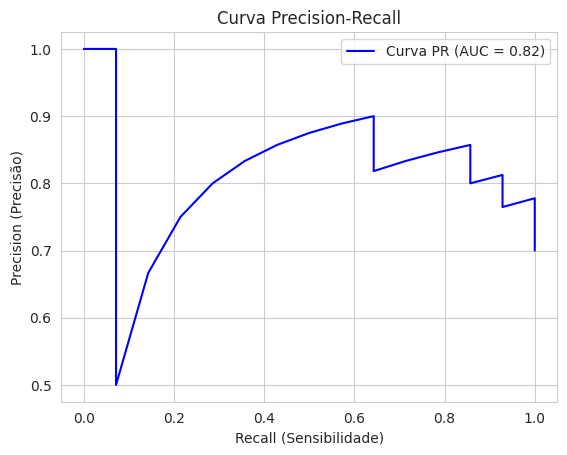

In [195]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Your code for prediction and Precision-Recall curve
y_scores = model_refit.predict_proba(X_test_oos)[:, 1]
precision, recall, _ = precision_recall_curve(y_test_oos, y_scores)

# Calculate the AUC for Precision-Recall curve
pr_auc = auc(recall, precision)

# Plotting the Precision-Recall curve with AUC
plt.plot(recall, precision, label=f'Curva PR (AUC = {pr_auc:.2f})', color='blue')  # Adjust color here
plt.xlabel('Recall (Sensibilidade)')
plt.ylabel('Precision (Precisão)')
plt.title('Curva Precision-Recall')
plt.legend()
plt.show()


# 10. Explicabilidade

SHAP https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137

In [196]:
X_test.columns

Index(['Total_Bilirubin', 'Alkaline_Phosphatase', 'Alanine_Aminotransferase',
       'Aspartate_Aminotransferase', 'Total_Proteins', 'Albumin'],
      dtype='object')

In [197]:

# Explainer
explainer = shap.Explainer(model_refit.predict, X_test.values,  feature_names=X_test.columns) #Aplicamos o explainer no modelo selecionado
# Calculando SHAP (pode demorar)
shap_values = explainer(X_test.values)

Exact explainer: 101it [00:12,  1.62it/s]


In [198]:
#Avaliando a importância das features conforme o algoritmo SHAP
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    # Calcula a importância (valor médio absoluto de SHAP) para cada atributo
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    # Calcula a normalização
    importances_norm = softmax(importances)
    # Salva em dicionario
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Orderna o dicionário
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Imprime os valores
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

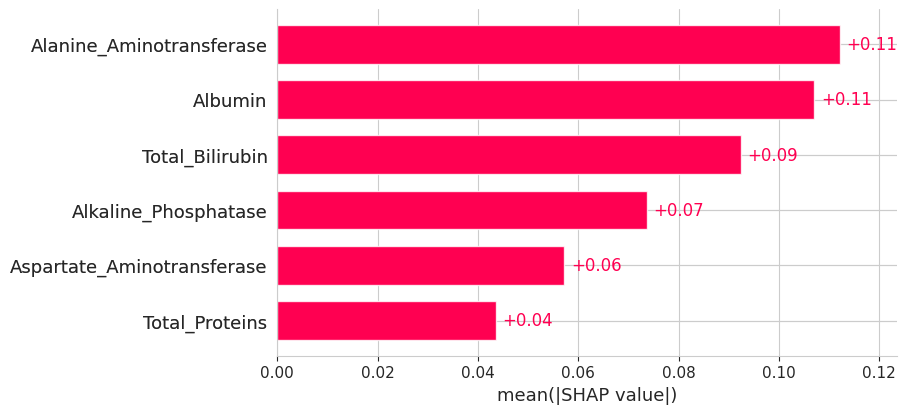

In [199]:
#Efeito global das features
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


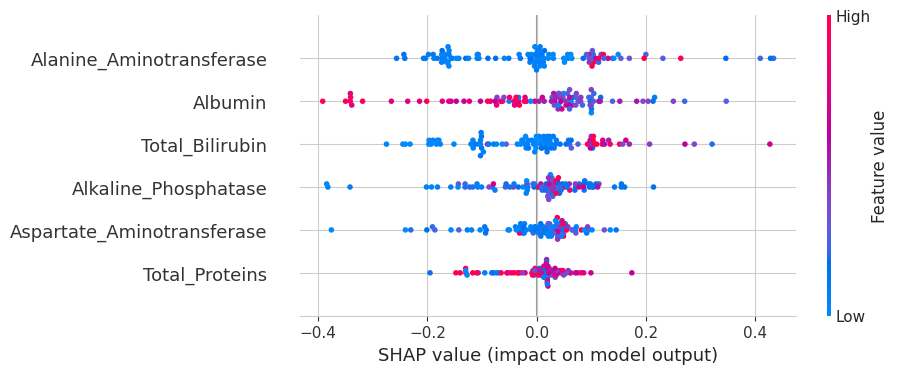

In [200]:
#Summary plot: beeswarm
shap.plots.beeswarm(shap_values)

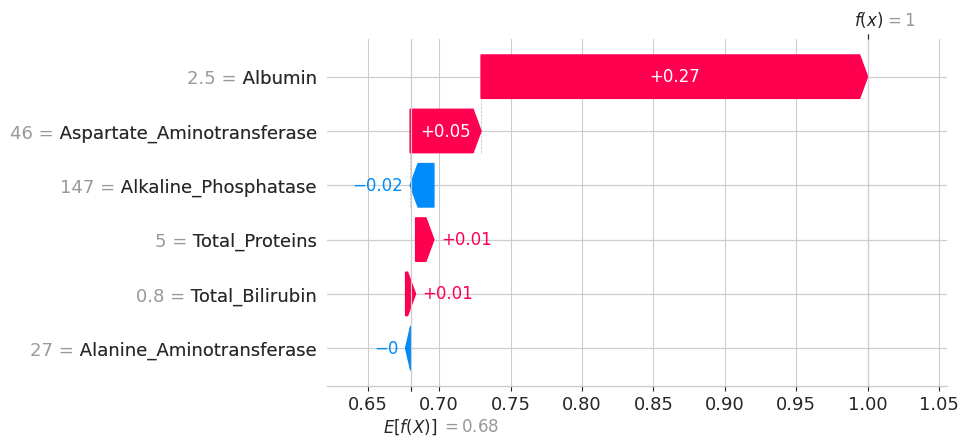

In [201]:
#Inspecionando um resultado utilizando SHAP
shap.plots.waterfall(shap_values[0]) #Substituir o número entre brackets pelo número da instância a ser inspecionada

# 11. Deploy

Retreinando o modelo com todos os dados disponíveis e realizando a serialização utilizando a biblioteca pickle.

In [202]:
model = results_dict['estimator']['Random Forest'].fit(X, y)

In [203]:
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

# 12. Reprodutibilidade


## 12. 1 Bibliotecas Python

- absl-py==1.4.0
- aiohttp==3.8.5
- aiosignal==1.3.1
- alabaster==0.7.13
- albumentations==1.3.1
- altair==4.2.2
- annotated-types==0.5.0
- anyio==3.7.1
- appdirs==1.4.4
- argon2-cffi==23.1.0
- argon2-cffi-bindings==21.2.0
- array-record==0.4.1
- arviz==0.15.1
- astropy==5.3.2
- astunparse==1.6.3
- async-timeout==4.0.3
- attrs==23.1.0
- audioread==3.0.0
- autograd==1.6.2
- Babel==2.12.1
- backcall==0.2.0
- beautifulsoup4==4.11.2
- bleach==6.0.0
- blinker==1.4
- blis==0.7.10
- blosc2==2.0.0
- bokeh==3.2.2
- branca==0.6.0
- build==0.10.0
- CacheControl==0.13.1
- cachetools==5.3.1
- catalogue==2.0.9
- certifi==2023.7.22
- cffi==1.15.1
- chardet==5.2.0
- charset-normalizer==3.2.0
- chex==0.1.7
- click==8.1.7
- click-plugins==1.1.1
- cligj==0.7.2
- cloudpickle==2.2.1
- cmake==3.27.2
- cmdstanpy==1.1.0
- colorcet==3.0.1
- colorlover==0.3.0
- community==1.0.0b1
- confection==0.1.1
- cons==0.4.6
- contextlib2==21.6.0
- contourpy==1.1.0
- convertdate==2.4.0
- cryptography==41.0.3
- cufflinks==0.17.3
- cvxopt==1.3.2
- cvxpy==1.3.2
- cycler==0.11.0
- cymem==2.0.7
- Cython==0.29.36
- dask==2023.8.0
- datascience==0.17.6
- db-dtypes==1.1.1
- dbus-python==1.2.18
- debugpy==1.6.6
- decorator==4.4.2
- defusedxml==0.7.1
- distributed==2023.8.0
- distro==1.7.0
- dlib==19.24.2
- dm-tree==0.1.8
- docutils==0.18.1
- dopamine-rl==4.0.6
- duckdb==0.8.1
- earthengine-api==0.1.364
- easydict==1.10
- ecos==2.0.12
- editdistance==0.6.2
- en-core-web-sm @ https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.6.0/en_core_web_sm-3.6.0-py3-none-any.whl#sha256=83276fc78a70045627144786b52e1f2728ad5e29e5e43916ec37ea9c26a11212
- entrypoints==0.4
- ephem==4.1.4
- et-xmlfile==1.1.0
- etils==1.4.1
- etuples==0.3.9
- exceptiongroup==1.1.3
- fastai==2.7.12
- fastcore==1.5.29
- fastdownload==0.0.7
- fastjsonschema==2.18.0
- fastprogress==1.0.3
- fastrlock==0.8.1
- filelock==3.12.2
- Fiona==1.9.4.post1
- firebase-admin==5.3.0
- Flask==2.2.5
- flatbuffers==23.5.26
- flax==0.7.2
- folium==0.14.0
- fonttools==4.42.0
- frozendict==2.3.8
- frozenlist==1.4.0
- fsspec==2023.6.0
- future==0.18.3
- gast==0.4.0
- gcsfs==2023.6.0
- GDAL==3.4.3
- gdown==4.6.6
- gensim==4.3.1
- geographiclib==2.0
- geopandas==0.13.2
- geopy==2.3.0
- gin-config==0.5.0
- glob2==0.7
- google==2.0.3
- google-api-core==2.11.1
- google-api-python-client==2.84.0
- google-auth==2.17.3
- google-auth-httplib2==0.1.0
- google-auth-oauthlib==1.0.0
- google-cloud-bigquery==3.10.0
- google-cloud-bigquery-connection==1.12.1
- google-cloud-bigquery-storage==2.22.0
- google-cloud-core==2.3.3
- google-cloud-datastore==2.15.2
- google-cloud-firestore==2.11.1
- google-cloud-functions==1.13.2
- google-cloud-language==2.9.1
- google-cloud-storage==2.8.0
- google-cloud-translate==3.11.3
- google-colab @ file:///colabtools/dist/google-colab-1.0.0.tar.gz#sha256=48f3c83d2099fd0241a40a38905fac7bdc2673fadbc598ee9d5c0d5050b8dceb
- google-crc32c==1.5.0
- google-pasta==0.2.0
- google-resumable-media==2.5.0
- googleapis-common-protos==1.60.0
- googledrivedownloader==0.4
- graphviz==0.20.1
- greenlet==2.0.2
- grpc-google-iam-v1==0.12.6
- grpcio==1.57.0
- grpcio-status==1.48.2
- gspread==3.4.2
- gspread-dataframe==3.3.1
- gym==0.25.2
- gym-notices==0.0.8
- h5netcdf==1.2.0
- h5py==3.9.0
- holidays==0.30
- holoviews==1.17.1
- html5lib==1.1
- httpimport==1.3.1
- httplib2==0.22.0
- humanize==4.7.0
- hyperopt==0.2.7
- idna==3.4
- imageio==2.31.1
- imageio-ffmpeg==0.4.8
- imagesize==1.4.1
- imbalanced-learn==0.10.1
- imgaug==0.4.0
- importlib-metadata==6.8.0
- importlib-resources==6.0.1
- imutils==0.5.4
- inflect==7.0.0
- iniconfig==2.0.0
- intel-openmp==2023.2.0
- ipykernel==5.5.6
- ipython==7.34.0
- ipython-genutils==0.2.0
- ipython-sql==0.5.0
- ipywidgets==7.7.1
- itsdangerous==2.1.2
- jax==0.4.14
- jaxlib @ https://storage.googleapis.com/jax-releases/cuda11/jaxlib-0.4.14+cuda11.cudnn86-cp310-cp310-manylinux2014_x86_64.whl#sha256=09c439923a785df517e3f470158dd3e46de454a01eca80935eed4ba383b5e90a
- jeepney==0.7.1
- jieba==0.42.1
- Jinja2==3.1.2
- joblib==1.3.2
- jsonpickle==3.0.2
- jsonschema==4.19.0
- jsonschema-specifications==2023.7.1
- jupyter-client==6.1.12
- jupyter-console==6.1.0
- jupyter-server==1.24.0
- jupyter_core==5.3.1
- jupyterlab-pygments==0.2.2
- jupyterlab-widgets==3.0.8
- kaggle==1.5.16
- keras==2.12.0
- keyring==23.5.0
- kiwisolver==1.4.4
- langcodes==3.3.0
- launchpadlib==1.10.16
- lazr.restfulclient==0.14.4
- lazr.uri==1.0.6
- lazy_loader==0.3
- libclang==16.0.6
- librosa==0.10.1
- lightgbm==4.0.0
- linkify-it-py==2.0.2
- lit==16.0.6
- llvmlite==0.39.1
- locket==1.0.0
- logical-unification==0.4.6
- LunarCalendar==0.0.9
- lxml==4.9.3
- Markdown==3.4.4
- markdown-it-py==3.0.0
- MarkupSafe==2.1.3
- matplotlib==3.7.1
- matplotlib-inline==0.1.6
- matplotlib-venn==0.11.9
- mdit-py-plugins==0.4.0
- mdurl==0.1.2
- miniKanren==1.0.3
- missingno==0.5.2
- mistune==0.8.4
- mizani==0.9.2
- mkl==2023.2.0
- ml-dtypes==0.2.0
- mlxtend==0.22.0
- more-itertools==10.1.0
- moviepy==1.0.3
- mpmath==1.3.0
- msgpack==1.0.5
- multidict==6.0.4
- multipledispatch==1.0.0
- multitasking==0.0.11
- murmurhash==1.0.9
- music21==9.1.0
- natsort==8.4.0
- nbclassic==1.0.0
- nbclient==0.8.0
- nbconvert==6.5.4
- nbformat==5.9.2
- nest-asyncio==1.5.7
- networkx==3.1
- nibabel==4.0.2
- nltk==3.8.1
- notebook==6.5.5
- notebook_shim==0.2.3
- numba==0.56.4
- numexpr==2.8.5
- numpy==1.23.5
- oauth2client==4.1.3
- oauthlib==3.2.2
- opencv-contrib-python==4.8.0.76
- opencv-python==4.8.0.76
- opencv-python-headless==4.8.0.76
- openpyxl==3.1.2
- opt-einsum==3.3.0
- optax==0.1.7
- orbax-checkpoint==0.3.4
- osqp==0.6.2.post8
- packaging==23.1
- pandas==1.5.3
- pandas-datareader==0.10.0
- pandas-gbq==0.17.9
- pandocfilters==1.5.0
- panel==1.2.1
- param==1.13.0
- parso==0.8.3
- partd==1.4.0
- pathlib==1.0.1
- pathy==0.10.2
- patsy==0.5.3
- pexpect==4.8.0
- pickleshare==0.7.5
- Pillow==9.4.0
- pip-tools==6.13.0
- platformdirs==3.10.0
- plotly==5.15.0
- plotnine==0.12.2
- pluggy==1.2.0
- polars==0.17.3
- pooch==1.7.0
- portpicker==1.5.2
- prefetch-generator==1.0.3
- preshed==3.0.8
- prettytable==3.8.0
- proglog==0.1.10
- progressbar2==4.2.0
- prometheus-client==0.17.1
- promise==2.3
- prompt-toolkit==3.0.39
- prophet==1.1.4
- proto-plus==1.22.3
- protobuf==3.20.3
- psutil==5.9.5
- psycopg2==2.9.7
- ptyprocess==0.7.0
- py-cpuinfo==9.0.0
- py4j==0.10.9.7
- pyarrow==9.0.0
- pyasn1==0.5.0
- pyasn1-modules==0.3.0
- pycocotools==2.0.7
- pycparser==2.21
- pyct==0.5.0
- pydantic==2.2.0
- pydantic_core==2.6.0
- pydata-google-auth==1.8.2
- pydot==1.4.2
- pydot-ng==2.0.0
- pydotplus==2.0.2
- PyDrive==1.3.1
- PyDrive2==1.6.3
- pyerfa==2.0.0.3
- pygame==2.5.1
- Pygments==2.16.1
- PyGObject==3.42.1
- PyJWT==2.3.0
- pymc==5.7.2
- PyMeeus==0.5.12
- pymystem3==0.2.0
- PyOpenGL==3.1.7
- pyOpenSSL==23.2.0
- pyparsing==3.1.1
- pyproj==3.6.0
- pyproject_hooks==1.0.0
- PySocks==1.7.1
- pytensor==2.14.2
- pytest==7.4.0
- python-apt==0.0.0
- python-dateutil==2.8.2
- python-louvain==0.16
- python-slugify==8.0.1
- python-utils==3.7.0
- pytz==2023.3
- pyviz_comms==3.0.0
- PyWavelets==1.4.1
- PyYAML==6.0.1
- pyzmq==23.2.1
- qdldl==0.1.7.post0
- qudida==0.0.4
- referencing==0.30.2
- regex==2023.6.3
- requests==2.31.0
- requests-oauthlib==1.3.1
- requirements-parser==0.5.0
- rich==13.5.2
- rpds-py==0.9.2
- rpy2==3.4.2
- rsa==4.9
- scikit-image==0.19.3
- scikit-learn==1.2.2
- scipy==1.10.1
- scs==3.2.3
- seaborn==0.12.2
- SecretStorage==3.3.1
- Send2Trash==1.8.2
- shap==0.42.1
- shapely==2.0.1
- six==1.16.0
- sklearn-pandas==2.2.0
- slicer==0.0.7
- smart-open==6.3.0
- sniffio==1.3.0
- snowballstemmer==2.2.0
- sortedcontainers==2.4.0
- soundfile==0.12.1
- soupsieve==2.4.1
- soxr==0.3.6
- spacy==3.6.1
- spacy-legacy==3.0.12
- spacy-loggers==1.0.4
- Sphinx==5.0.2
- sphinxcontrib-applehelp==1.0.7
- sphinxcontrib-devhelp==1.0.5
- sphinxcontrib-htmlhelp==2.0.4
- sphinxcontrib-jsmath==1.0.1
- sphinxcontrib-qthelp==1.0.6
- sphinxcontrib-serializinghtml==1.1.8
- SQLAlchemy==2.0.20
- sqlparse==0.4.4
- srsly==2.4.7
- statsmodels==0.14.0
- sympy==1.12
- tables==3.8.0
- tabulate==0.9.0
- tbb==2021.10.0
- tblib==2.0.0
- tenacity==8.2.3
- tensorboard==2.12.3
- tensorboard-data-server==0.7.1
- tensorflow==2.12.0
- tensorflow-datasets==4.9.2
- tensorflow-estimator==2.12.0
- tensorflow-gcs-config==2.12.0
- tensorflow-hub==0.14.0
- tensorflow-io-gcs-filesystem==0.33.0
- tensorflow-metadata==1.14.0
- tensorflow-probability==0.20.1
- tensorstore==0.1.41
- termcolor==2.3.0
- terminado==0.17.1
- text-unidecode==1.3
- textblob==0.17.1
- tf-slim==1.1.0
- thinc==8.1.12
- threadpoolctl==3.2.0
- tifffile==2023.8.12
- tinycss2==1.2.1
- toml==0.10.2
- tomli==2.0.1
- toolz==0.12.0
- torch @ https://download.pytorch.org/whl/cu118/torch-2.0.1%2Bcu118-cp310-cp310-linux_x86_64.whl#sha256=a7a49d459bf4862f64f7bc1a68beccf8881c2fa9f3e0569608e16ba6f85ebf7b
- torchaudio @ https://download.pytorch.org/whl/cu118/torchaudio-2.0.2%2Bcu118-cp310-cp310-linux_x86_64.whl#sha256=26692645ea061a005c57ec581a2d0425210ac6ba9f923edf11cc9b0ef3a111e9
- torchdata==0.6.1
- torchsummary==1.5.1
- torchtext==0.15.2
- torchvision @ https://download.pytorch.org/whl/cu118/torchvision-0.15.2%2Bcu118-cp310-cp310-linux_x86_64.whl#sha256=19ca4ab5d6179bbe53cff79df1a855ee6533c2861ddc7389f68349d8b9f8302a
- tornado==6.3.2
- tqdm==4.66.1
- traitlets==5.7.1
- triton==2.0.0
- tweepy==4.13.0
- typer==0.9.0
- types-setuptools==68.1.0.0
- typing_extensions==4.7.1
- tzlocal==5.0.1
- uc-micro-py==1.0.2
- uritemplate==4.1.1
- urllib3==2.0.4
- vega-datasets==0.9.0
- wadllib==1.3.6
- wasabi==1.1.2
- wcwidth==0.2.6
- webcolors==1.13
- webencodings==0.5.1
- websocket-client==1.6.1
- Werkzeug==2.3.7
- widgetsnbextension==3.6.5
- wordcloud==1.9.2
- wrapt==1.14.1
- xarray==2023.7.0
- xarray-einstats==0.6.0
- xgboost==1.7.6
- xlrd==2.0.1
- xyzservices==2023.7.0
- yarl==1.9.2
- yellowbrick==1.5
- yfinance==0.2.28
- zict==3.0.0
- zipp==3.16.2

## 12.2 Python


- 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]

## 12.3 Informações de CPU

- processor	: 0
- vendor_id	: GenuineIntel
- cpu family	: 6
- model		: 79
- model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
- stepping	: 0
- microcode	: 0xffffffff
- cpu MHz		: 2199.998
- cache size	: 56320 KB
- physical id	: 0
- siblings	: 2
- core id		: 0
- cpu cores	: 1
- apicid		: 0
- initial apicid	: 0
- fpu		: yes
- fpu_exception	: yes
- cpuid level	: 13
- wp		: yes
- flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
- bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
- bogomips	: 4399.99
- clflush size	: 64
- cache_alignment	: 64
- address sizes	: 46 bits physical, 48 bits virtual

- processor	: 1
- vendor_id	: GenuineIntel
- cpu family	: 6
- model		: 79
- model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
- stepping	: 0
- microcode	: 0xffffffff
- cpu MHz		: 2199.998
- cache size	: 56320 KB
- physical id	: 0
- siblings	: 2
- core id		: 0
- cpu cores	: 1
- apicid		: 1
- initial apicid	: 1
- fpu		: yes
- fpu_exception	: yes
- cpuid level	: 13
- wp		: yes
- flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
- bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
- bogomips	: 4399.99
- clflush size	: 64
- cache_alignment	: 64
- address sizes	: 46 bits physical, 48 bits virtual

## 12.4 Informações do sistema

- Distributor ID:	Ubuntu
- Description:	Ubuntu 22.04.2 LTS
- Release:	22.04
- Codename:	jammy